In [1]:
#
# Run the hbv parameter estimation with full model
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [18]:
from kipet import KipetModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import t
from scipy.linalg import eig
import scipy.linalg as sla

In [4]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/hbv_data.csv'
C_data = pd.read_csv(filename, index_col = 0)
C_data.shape

(50, 3)

In [5]:
C_data.head()

,A,B,C
0.000000,1.051482,-0.000739,-0.000501
2.040816,0.718060,2.599459,371.265832
4.081633,0.641247,5.702485,325.080882
6.122449,0.657471,6.944847,296.171685
8.163265,0.772015,9.147780,291.254375


In [6]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('A', state = 'concentration', init = 1.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

r1.add_parameter('k1',init = 100, bounds=(0.0,5e3))
r1.add_parameter('k2',init = 100, bounds=(0.0,5e3))
r1.add_parameter('k3',init = 100, bounds=(0.0,5e3))
r1.add_parameter('k4',init = 100, bounds=(0.0,5e3))
r1.add_parameter('k5',init = 100, bounds=(0.0,5e3))
r1.add_parameter('k6',init = 100, bounds=(0.0,5e3))


In [8]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = m.P['k2']*m.Z[t,'B'] - m.P['k4']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']-m.P['k6']*m.Z[t,'B']*m.Z[t,'C']
    exprs['C'] = m.P['k3']*m.Z[t,'A']-m.P['k5']*m.Z[t,'C']-m.P['k6']*m.Z[t,'B']*m.Z[t,'C']
    return exprs

r1.add_equations(rule_odes)
r1.set_times(0.0,100.0)

In [9]:
r1.add_dataset('C_data', category = 'concentration', data = C_data)

In [12]:
# sigmas as 1/wts used in the book
r1.variances = {'A':1, 'B':100, 'C':1e4}
r1.settings.parameter_estimator['solver'] = 'k_aug'
r1.settings.solver.linear_solver = 'ma27'
r1.run_opt()

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
0.0 100.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/para

  62  1.2424663e+06 5.17e+02 5.57e+12  -1.0 1.81e+02  13.3 2.97e-07 8.42e-05F  1
  63  1.2474174e+06 3.54e+03 9.03e+18  -1.0 1.81e+02  12.8 1.27e-06 5.00e-01h  2
  64  1.2655739e+06 1.19e+03 8.96e+18  -1.0 3.15e+02  13.2 8.77e-02 3.02e-01h  2
  65  1.2756405e+06 9.76e+02 4.41e+19  -1.0 9.86e+01  15.4 8.39e-01 1.83e-01h  3
  66  1.2840164e+06 7.32e+02 2.15e+21  -1.0 1.08e+02  16.8 4.86e-01 1.72e-01h  3
  67  1.2944134e+06 4.42e+02 8.37e+21  -1.0 1.10e+02  17.2 7.26e-01 3.53e-01h  2
  68  1.2942987e+06 4.33e+02 6.48e+21  -1.0 9.78e+01  17.6 3.98e-01 2.07e-02F  1
  69  1.2942188e+06 4.16e+02 1.49e+22  -1.0 1.06e+02  19.0 7.34e-01 4.03e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2937538e+06 1.79e+02 1.37e+23  -1.0 1.33e+02  18.5 1.05e-04 5.53e-01f  1
  71  1.2929549e+06 2.34e+02 1.49e+26  -1.0 1.51e+02  18.9 5.17e-01 8.04e-01f  1
  72r 1.2929549e+06 2.34e+02 9.99e+02   2.1 0.00e+00  20.0 0.00e+00 0.00e+00R  1
  73r 1.2930207e+06 1.86e+02

 168  1.3261387e+06 1.22e+02 6.75e+06  -1.0 9.04e+01   7.1 9.72e-01 7.01e-04h  1
 169r 1.3261387e+06 1.22e+02 9.99e+02   1.8 0.00e+00   6.7 0.00e+00 4.43e-07R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 1.3262730e+06 5.24e+01 4.24e+03   1.8 1.31e+04    -  1.01e-02 3.60e-03f  1
 171  1.3241055e+06 5.06e+01 6.25e+02  -1.0 4.93e+02    -  4.56e-03 2.59e-02f  1
 172  1.3239268e+06 5.05e+01 7.28e+02  -1.0 2.00e+03    -  2.10e-03 2.10e-03f  1
 173r 1.3239268e+06 5.05e+01 9.99e+02   1.4 0.00e+00   6.2 0.00e+00 3.58e-07R  5
 174r 1.3239787e+06 3.81e+01 3.52e+03   1.4 3.94e+03    -  9.10e-03 4.47e-03f  1
 175  1.3239295e+06 3.81e+01 2.53e+02  -1.0 1.32e+03    -  8.27e-03 4.68e-04f  1
 176  1.3227958e+06 3.75e+01 8.47e+03  -1.0 5.89e+02    -  5.30e-01 1.42e-02f  1
 177r 1.3227958e+06 3.75e+01 1.00e+03   1.3 0.00e+00   5.7 0.00e+00 3.78e-07R  2
 178r 1.3228089e+06 3.48e+01 1.63e+03   1.3 4.49e+03    -  1.92e-02 4.81e-03f  1
 179r 1.3228619e+06 3.42e+01

 261  1.2359684e+06 8.38e+06 9.96e+12  -1.0 4.09e+01  12.4 9.87e-01 1.13e-03h  1
 262  1.2359685e+06 8.38e+06 9.96e+12  -1.0 4.09e+01  11.9 9.91e-01 1.13e-05h  1
 263r 1.2359685e+06 8.38e+06 1.00e+03   6.6 0.00e+00  11.4 0.00e+00 1.45e-07R  2
 264r 1.2250644e+06 2.53e+06 1.24e+06   6.6 3.47e+09    -  1.19e-04 1.20e-03f  1
 265  1.1757346e+06 3.89e+05 1.29e+03  -1.0 2.49e+04    -  6.83e-01 1.35e-01f  1
 266  1.0803773e+06 3.18e+05 2.03e+04  -1.0 7.42e+03    -  4.64e-02 3.93e-01f  1
 267  1.0319603e+06 1.67e+05 7.52e+05  -1.0 8.19e+03    -  2.54e-02 2.60e-01f  1
 268  1.0608934e+06 7.37e+04 2.67e+21  -1.0 7.11e+03  10.9 9.28e-01 5.42e-01h  1
 269  1.0224528e+06 4.17e+04 2.69e+21  -1.0 8.21e+03  11.3 1.56e-01 4.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.0224054e+06 4.16e+04 2.68e+21  -1.0 3.77e+03  11.8 4.79e-01 2.97e-03f  1
 271  1.0224044e+06 4.16e+04 2.68e+21  -1.0 3.91e+03  11.3 5.16e-01 3.17e-05h  1
 272r 1.0224044e+06 4.16e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.3249185e+06 7.55e-02 1.58e+03  -1.0 1.31e+00   1.9 1.00e+00 4.80e-03f  1
 371  1.3248815e+06 7.33e-02 1.05e+04  -1.0 2.31e+00   1.4 7.04e-01 2.92e-02f  1
 372  1.3208961e+06 1.29e-01 1.18e+04  -1.0 4.68e+00   0.9 1.00e+00 1.00e+00f  1
 373  1.3103014e+06 1.83e+00 4.68e+04  -1.0 7.38e+00   0.5 3.48e-01 1.00e+00f  1
 374  1.3098961e+06 1.22e-01 4.86e+04  -1.0 4.19e-01   1.8 2.52e-02 1.00e+00f  1
 375  1.2872196e+06 2.76e+01 9.92e+04  -1.0 3.71e+01    -  1.18e-02 7.36e-01f  1
 376  1.2871403e+06 1.80e+00 4.94e+04  -1.0 2.13e+00   2.2 1.00e+00 1.00e+00f  1
 377  1.2869997e+06 6.93e-01 3.42e+04  -1.0 1.27e+00   1.7 1.00e+00 1.00e+00f  1
 378  1.2870165e+06 2.32e-02 8.05e+03  -1.0 7.40e-01   1.3 1.00e+00 1.00e+00h  1
 379  1.2867496e+06 1.51e-01 8.43e+02  -1.0 6.04e-01   0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  1.2860928e+06 8.08e-01

 473  1.5780471e+04 1.75e-11 4.69e-07  -9.0 8.79e-12    -  1.00e+00 5.00e-01h  2
 474  1.5780471e+04 1.82e-11 9.67e-07  -9.0 9.60e-12    -  1.00e+00 1.00e+00h  1
 475  1.5780471e+04 1.75e-11 7.20e-08  -9.0 1.02e-11    -  1.00e+00 1.00e+00H  1
 476  1.5780471e+04 2.35e-11 6.98e-07  -9.0 1.09e-11    -  1.00e+00 1.00e+00h  1
 477  1.5780471e+04 1.73e-11 1.05e-07  -9.0 1.14e-11    -  1.00e+00 5.00e-01h  2
 478  1.5780471e+04 1.48e-11 3.78e-07  -9.0 7.56e-12    -  1.00e+00 1.00e+00h  1
 479  1.5780471e+04 1.49e-11 2.45e-07  -9.0 5.71e-12    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  1.5780471e+04 1.49e-11 6.07e-07  -9.0 8.56e-12    -  1.00e+00 5.00e-01h  2
 481  1.5780471e+04 1.50e-11 2.52e-07  -9.0 6.46e-12    -  1.00e+00 2.50e-01h  3
 482  1.5780471e+04 1.55e-11 2.82e-07  -9.0 7.11e-12    -  1.00e+00 1.00e+00h  1
 483  1.5780471e+04 1.02e-11 3.54e-07  -9.0 8.51e-12    -  1.00e+00 5.00e-01h  2
 484  1.5780471e+04 1.47e-11

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018



W[K_AUG]...	[K_AUG_ASL]Variable "455" (offset 6) has an active bound; sigma = 12.682373.


: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 909
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 6
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-9.025743792811024 at var_i=450
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-9.025743792811024 at var_i=451
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 5103
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 1350
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 15780.470851
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 759
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_RH]Accordin


RESULTS
Z:
                     A           B             C
0.000000     1.000000    0.000000      0.000000
0.316431     0.937082    0.641421     43.527821
1.316222     0.787285    2.410274    143.376905
2.040816     0.717006    3.504472    189.117746
2.357247     0.694402    3.946839    204.282867
...               ...         ...           ...
97.234590   42.715099  431.913538  21689.302183
97.959184   42.720336  431.994507  21689.070583
98.275615   42.722747  432.028704  21689.151654
99.275406   42.730719  432.131647  21690.040600
100.000000  42.736727  432.201141  21691.205569

[151 rows x 3 columns]

Cm:
                     A           B             C
0.000000     1.051482   -0.000739     -0.000501
2.040816     0.718060    2.599459    371.265832
4.081633     0.641247    5.702485    325.080882
6.122449     0.657471    6.944847    296.171685
8.163265     0.772015    9.147780    291.254375
10.204082    0.798199   12.125293    416.872613
12.244898    1.147047   15.880887    518.2094

In [13]:
print("The estimated parameters are:")
r1.results.show_parameters

The estimated parameters are:

The estimated parameters are:
k1 2.104144283485672
k2 0.021076208210621308
k3 149.4111085376045
k4 0.21295003420695
k5 0.29056702429583636
k6 8.61040838358464e-06


In [15]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = r1.results.objective / (C_data.shape[0]*3 - 6)
cov_est = 2 * mse * r1.results.parameter_covariance
cov_est

array([[ 2.23603297e-02, -1.40344920e-03, -1.03684892e+00,
        -1.35277315e-02, -2.83368028e-03,  1.39950384e-07],
       [-1.40344920e-03,  1.42668084e-04,  1.30290118e-01,
         1.50347671e-03,  2.60413106e-04, -1.59092047e-08],
       [-1.03684892e+00,  1.30290118e-01,  7.84800012e+02,
         1.44165757e+00,  1.50600685e+00, -1.80216554e-05],
       [-1.35277315e-02,  1.50347671e-03,  1.44165757e+00,
         1.60476716e-02,  2.73684839e-03, -1.71058663e-07],
       [-2.83368028e-03,  2.60413106e-04,  1.50600685e+00,
         2.73684839e-03,  3.08435682e-03, -3.28003086e-08],
       [ 1.39950384e-07, -1.59092047e-08, -1.80216554e-05,
        -1.71058663e-07, -3.28003086e-08,  1.86876103e-12]])

In [19]:
# calculate conf delta (p = p_est +/- conf_delta) and % conf_delta = conf_delta/p_est
dof = C_data.shape[0]*3 - 6
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
print('conf_delta')
print(conf_delta)
print('% conf delta')
print(conf_delta * 100/ np.array(list(r1.results.P.values())))

conf_delta
[2.95564598e-01 2.36089530e-02 5.53723319e+01 2.50391353e-01
 1.09773022e-01 2.70203019e-06]
% conf delta
[ 14.04678376 112.01707976  37.06038487 117.5822083   37.77889873
  31.38097601]


In [20]:
# In the book (after converting log10(k) to k), the value of conf_delta and % conf delta is the following
p_est_jbr = 10 ** np.array([0.32, -1.5, 3.5, -0.49, 0.85, -5.08])
conf_delta_jbr = 10 ** np.array([0.17, 1.85, 18.3, 1.91, 18.3, 0.32])
conf_delta_pct_jbr = conf_delta_jbr * 100/ p_est_jbr
print('conf delta book')
print(conf_delta_jbr)
print('% conf delta book')
print(conf_delta_pct_jbr)

conf delta book
[1.47910839e+00 7.07945784e+01 1.99526231e+18 8.12830516e+01
 1.99526231e+18 2.08929613e+00]
% conf delta book
[7.07945784e+01 2.23872114e+05 6.30957344e+16 2.51188643e+04
 2.81838293e+19 2.51188643e+07]


The confidence intervals in the book are very wide and they suggest how to reduce the model. I am not sure why the confidence intervals from kipet are very tight. The data is a bit different since it is generated with random noise. Still it is hard to envision such a large difference. It needs to be looked into further.

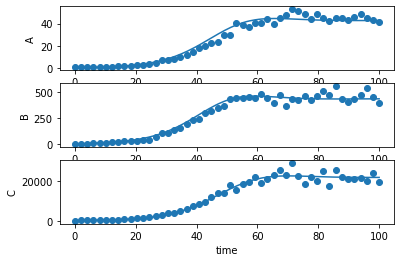

In [22]:
fig, ax = plt.subplots(3)
cmplist = ['A', 'B', 'C']
for (i, c) in enumerate(cmplist):
    ax[i].scatter(r1.results.Cm.index, r1.results.Cm[c])
    ax[i].plot(r1.results.Z.index, r1.results.Z[c])
    ax[i].set_xlabel('time')
    ax[i].set_ylabel(c)

In the book, they look at the covariance matrix of parameters (which are log10(k)). To look at a covariance matrix for ln(k) we need to do the following transformation of the estimated covariance matrix
$$ Cov(ln(k)) = Diag(k)^{-1}Cov(k)Diag(k)^{-1} $$

In [23]:
# scaled covariance
k_diag_inv = np.diag(1 / np.array(list(r1.results.P.values())))
cov_est_scaled = np.dot(np.dot(k_diag_inv, cov_est), k_diag_inv)
cov_est_scaled

array([[ 0.00505042, -0.03164672, -0.00329805, -0.0301906 , -0.00463478,
         0.00772458],
       [-0.03164672,  0.3211751 ,  0.04137482,  0.33498589,  0.04252301,
        -0.08766621],
       [-0.00329805,  0.04137482,  0.0351555 ,  0.04531078,  0.03468948,
        -0.01400838],
       [-0.0301906 ,  0.33498589,  0.04531078,  0.35388047,  0.04423099,
        -0.09329183],
       [-0.00463478,  0.04252301,  0.03468948,  0.04423099,  0.03653187,
        -0.01311016],
       [ 0.00772458, -0.08766621, -0.01400838, -0.09329183, -0.01311016,
         0.02520614]])

In [24]:
eigval, eigvec = sla.eig(cov_est_scaled)

In [25]:
eigval, max(eigval) / min(eigval)

(array([7.12465634e-01+0.j, 5.83282477e-02+0.j, 5.15796266e-03+0.j,
        7.91899100e-04+0.j, 1.22501660e-05+0.j, 2.43502145e-04+0.j]),
 (58159.67172602709+0j))

In [26]:
eigvec[:, 4], eigvec[:, 5]

(array([-0.59699895, -0.51880256, -0.02863722,  0.52246646,  0.03589106,
         0.31520897]),
 array([ 0.09699673,  0.2301467 ,  0.49426341, -0.03153523, -0.43511979,
         0.70922783]))